Könyvtárak importálása

In [ ]:
import cv2 # OpenCv könyvtár importálása
import numpy as np # grafikonok megjelenítéséhez
import matplotlib.pyplot as plt # grafikonok megjelenítéséhez
import seaborn as sns # grafikonok megjelenítéséhez
from google.colab.patches import cv2_imshow # képek megjelenítéséhez
import zipfile # zip kicsomagoláshoz
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator #képek beolvasásához
from keras.models import Sequential # tensorflow neurális háló létrehozásához
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization #neurális hálózati rétegek kialakításához


Csatlakozás a Google Drive-omhoz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


adathalmazt tartalmazó zip könyvtár kicsomagolása

In [ ]:
path = '/content/drive/MyDrive/Diplomamunka/dataset.zip'
zip_file = zipfile.ZipFile(file=path, mode='r')
zip_file.extractall('./')
zip_file.close()

Tanuló és teszt adathalmaz létrehozása

In [ ]:
training_generator = ImageDataGenerator(1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/dataset/train', target_size=(48,48), batch_size=16, class_mode='categorical', shuffle=True)

Found 28709 images belonging to 7 classes.


Osztályok és bennük lévő képek száma:

In [ ]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

Osztálycímkék:

In [ ]:
train_dataset.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

<Axes: ylabel='count'>

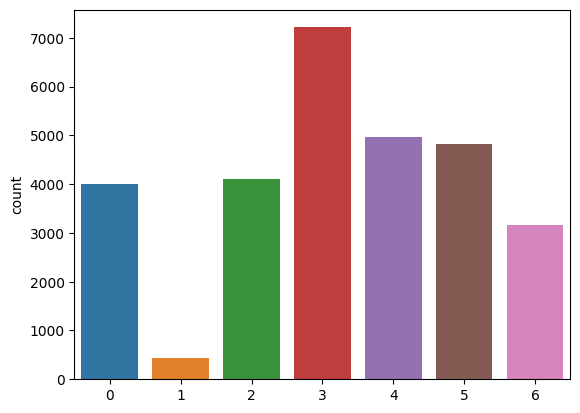

In [ ]:
sns.countplot(x = train_dataset.classes)

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/dataset/test', target_size=(48,48), batch_size=1, class_mode='categorical', shuffle=False)

Found 7178 images belonging to 7 classes.


In [ ]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
num_detectors = 32
num_classes = 7
width, height = 48,48
epochs = 100

network = Sequential()

network.add(Conv2D( num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3) ))
network.add(BatchNormalization())
network.add(Conv2D( num_detectors, (3,3), activation='relu', padding = 'same' ))
network.add(BatchNormalization())
network.add(MaxPooling2D( pool_size=(2,2) ))
network.add(Dropout(0.2))

network.add(Conv2D( 2 * num_detectors, (3,3), activation='relu', padding = 'same' ))
network.add(BatchNormalization())
network.add(Conv2D( 2 * num_detectors, (3,3), activation='relu', padding = 'same' ))
network.add(BatchNormalization())
network.add(MaxPooling2D( pool_size=(2,2) ))
network.add(Dropout(0.2))

network.add(Conv2D( 2 * 2 * num_detectors, (3,3), activation='relu', padding = 'same' ))
network.add(BatchNormalization())
network.add(Conv2D( 2 * 2 * num_detectors, (3,3), activation='relu', padding = 'same' ))
network.add(BatchNormalization())
network.add(MaxPooling2D( pool_size=(2,2) ))
network.add(Dropout(0.2))

network.add(Conv2D( 2 * 2 * 2 * num_detectors, (3,3), activation='relu', padding = 'same' ))
network.add(BatchNormalization())
network.add(Conv2D( 2 * 2 * 2 * num_detectors, (3,3), activation='relu', padding = 'same' ))
network.add(BatchNormalization())
network.add(MaxPooling2D( pool_size=(2,2) ))
network.add(Dropout(0.2))

network.add(Flatten())  # a létrejött mátrix vektorrá alakítása

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))
print(network.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                        

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
network.fit(train_dataset, epochs=130)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/130
1795/1795 [==============================] - 807s 446ms/step - loss: 1.8765 - accuracy: 0.2553
Epoch 2/130
1795/1795 [==============================] - 783s 436ms/step - loss: 1.5995 - accuracy: 0.3764
Epoch 3/130
1795/1795 [==============================] - 787s 438ms/step - loss: 1.4293 - accuracy: 0.4495
Epoch 4/130
1795/1795 [==============================] - 788s 439ms/step - loss: 1.3418 - accuracy: 0.4863
Epoch 5/130
1795/1795 [==============================] - 787s 438ms/step - loss: 1.2840 - accuracy: 0.5161
Epoch 6/130
1795/1795 [==============================] - 786s 438ms/step - loss: 1.2371 - accuracy: 0.5339
Epoch 7/130
1683/1795 [===========================>..] - ETA: 47s - loss: 1.2028 - accuracy: 0.5494